In [1]:
using CuArrays
using AutoGrad
using Deeplearning
using Statistics
using StatsBase
using Plots
import CSV

┌ Info: Recompiling stale cache file /Users/aliceylan/.julia/compiled/v1.1/Deeplearning/gtjFf.ji for Deeplearning [0d5bc7a0-39dd-11e9-2aab-59c8d4b467de]
└ @ Base loading.jl:1184
┌ Warning: Package Deeplearning does not have LinearAlgebra in its dependencies:
│ - If you have Deeplearning checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Deeplearning
└ Loading LinearAlgebra into Deeplearning from project dependency, future warnings for Deeplearning are suppressed.


In [29]:
batch = 100
learning_rate = 10e-4

0.001

In [12]:
train = CSV.read("datasets/digit-recognizer/train.csv")
xtrain = []
ytrain = []
for i in 1:size(train)[1]
    max = maximum(train[i,2:end])+0.1
    normalized = reshape(train[i, 2:end]./(max), (28,28,1,1))
    push!(xtrain, cu(normalized))
    push!(ytrain, train[i,1]+1)
end
println("Ready...")

Ready...


In [15]:
randnfloat32 = @float32 randn

(::getfield(Deeplearning, Symbol("#g#1")){Symbol}) (generic function with 1 method)

In [30]:
conv1 = Deeplearning.ConvolutionLayer((3,3,6), (2,2), (1,1), randnfloat32, relu)((28,28,1,1))
conv2 = Deeplearning.ConvolutionLayer((3,3,16), (2,2), (1,1), randnfloat32, relu)(conv1.telemetry.o)
dense1 = Deeplearning.FullyConnectedLayer(120, randnfloat32, relu)(conv2.telemetry.o)
dense2 = Deeplearning.FullyConnectedLayer(84, randnfloat32, relu)(dense1.telemetry.o)
dense3 = Deeplearning.FullyConnectedLayer(10, randnfloat32, relu)(dense2.telemetry.o)
layers=[dense3.bias,dense3.matrix,dense2.bias,dense2.matrix,dense1.bias,dense1.matrix,conv2.bias,conv2.matrix,conv1.bias,conv1.matrix]
println("Loaded")

Loaded


In [31]:
function f(x)
    x = conv1(x)    
    x = conv2(x)    
    x = dense1(x)
    x = dense2(x)
    x = dense3(x)
    x = softmax(x)
end

f (generic function with 1 method)

In [32]:
acc_train_plot = []
acc_test_plot = []
loss_train_plot = []
loss_test_plot = []

0-element Array{Any,1}

In [33]:
dff(x,y) = @diff nll(f(x), y)

for e in 1:5
    println("Epoch ", e)
    indices = sample(1:size(train)[1], size(train)[1], replace = false)
    for (ei,si) in enumerate(1:batch:size(indices)[1])
        sample_batch_x, sample_batch_y = cat(xtrain[indices[(si):(ei*batch)]]..., dims=4), hcat(ytrain[indices[(si):(ei*batch)]]...)

        dv = dff(sample_batch_x, sample_batch_y)

        dparams = @parameters dv
                
        for pidx in 1:length(dparams[1:end-1])
            dw = grad(dv, dparams[pidx])
            layers[pidx] .-=learning_rate*dw
        end
    end
    otrain = hcat([collect(f(xtr)) for xtr in xtrain]...)
#     otest = f(xtest)
    push!(acc_train_plot, acc(otrain, ytrain))
    push!(loss_train_plot, nll(otrain, ytrain))
#     push!(acc_test_plot, acc(o, ytest))
#     push!(loss_test_plot, nll(o, ytest))
end

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


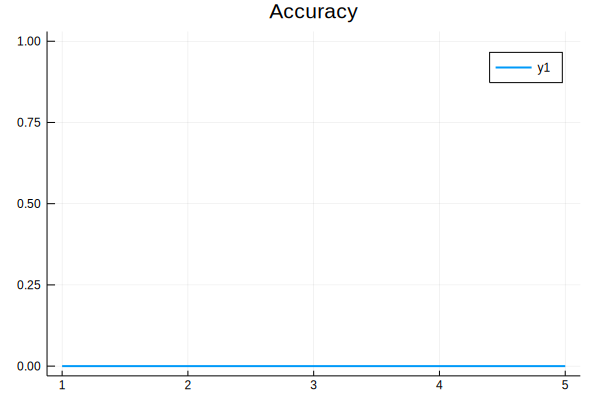

In [36]:
plot([acc_train_plot], linewidth=2, title="Accuracy")

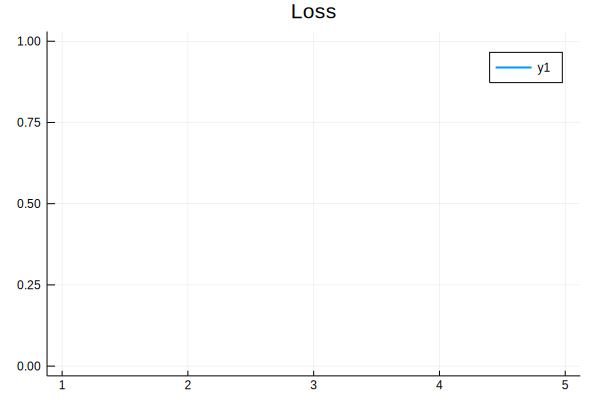

In [37]:
plot([loss_train_plot], linewidth=2, title="Loss")